In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import normaltest
import os
import pickle
import gc
import warnings

warnings.filterwarnings('ignore')

In [2]:
# load data
with open('sentiment_data/sentiment_sector_dict.pkl', 'rb') as file:
    senti_dict = pickle.load(file)
    
with open('sentiment_data/sentiment_summary_dict(1).pkl', 'rb') as file:
    senti_dict1 = pickle.load(file)

In [6]:
# related functions
def sentiment_contrast(senti_daily, proxy_data, col):
    """
    Visualizes comparison between sentiment metrics and market proxy data.
    
    Parameters:
        senti_daily (DataFrame): Daily sentiment data with datetime index
        proxy_data (DataFrame): Market proxy data with 'dt' date column
        col (str): Sentiment column name to visualize
    
    Features:
        - Automatic datetime conversion for index alignment
        - Dual-axis visualization with 20-day moving averages
        - Smart time period alignment between datasets
        - Quarterly date formatting for better temporal orientation
    """
    senti_daily = senti_daily.copy()
    if not isinstance(senti_daily.index, pd.DatetimeIndex):
        senti_daily.index = pd.to_datetime(senti_daily.index)
    if not isinstance(proxy_data['dt'], pd.DatetimeIndex):
        proxy_data['dt'] = pd.to_datetime(proxy_data['dt'])
    # Get overlapping time periods
    overlap_time = senti_daily[senti_daily.index.isin(proxy_data['dt'])].index
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(16, 6))
    
    temp1 = senti_daily[senti_daily.index.isin(overlap_time)]
    temp2 = proxy_data[proxy_data['dt'].isin(overlap_time)].set_index('dt')
    
    # Plot first line (roberta_pos) on primary y-axis
    line1 = ax1.plot(temp1[col].shift().rolling(20).mean(), 
                     color='blue', label=f'{col} (20-day MA)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{col}', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create secondary y-axis and plot second line
    ax2 = ax1.twinx()
    line2 = ax2.plot(temp2.rolling(20).mean(), 
                     color='red', label='Proxy Data (20-day MA)')
    ax2.set_ylabel('Proxy Value', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Add title and grid
    plt.title(f'{col} vs Proxy Data Comparison')
    ax1.grid(True, alpha=0.3)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()
    
    
def market_test(sentiment_cluster, sentiment_proxy, column_name_x, column_name_y):
    """
    Conducts rigorous statistical testing of market relationships.
    
    Parameters:
        sentiment_cluster (DataFrame): Independent variable dataset
        sentiment_proxy (DataFrame): Dependent variable dataset
        column_name_x (str): Independent variable column
        column_name_y (str): Dependent variable column
    
    Methodology:
        1. Data Integration: Merges datasets on datetime index
        2. Stationarity Enforcement: Automatic differencing with ADF test (max 10 diffs)
        3. Granger Causality: Tests predictive relationships at 5 lags
        4. VAR Modeling: Implements Vector Autoregression with AIC optimization
        5. Diagnostic Checks: Residual autocorrelation and normality tests
    
    Returns:
        tuple: (Granger test results, VAR model results)
    """
    data_ = pd.merge(sentiment_cluster, sentiment_proxy, left_index=True, right_on='dt')
    data = pd.DataFrame({'x': data_[column_name_x].values, 'y': data_[column_name_y].values})
       
    y_diff = data['y'].copy()
    diff_order_y = 0
    while True:
        y_adf = adfuller(y_diff)
        if y_adf[1] <= 0.05:
            break
        y_diff = y_diff.diff().dropna()
        diff_order_y += 1
        if diff_order_y > 10:  # Prevents infinite loops
            raise ValueError("After several differential scores, the ADF test is still not passed")
            
    x_diff = data['x'].copy()
    diff_order_x = 0
    while True:
        x_adf = adfuller(x_diff)
        if x_adf[1] <= 0.05:
            break
        x_diff = x_diff.diff().dropna()
        diff_order_x += 1
        if diff_order_x > 10:  # Prevents infinite loops
            raise ValueError("After several differential scores, the ADF test is still not passed")
    diff_o = diff_order_x + diff_order_y
    data = pd.DataFrame({'x': x_diff.values[diff_o:], 'y': y_diff.values[diff_o:]})
    # Perform the Granger causality test
    granger_test = grangercausalitytests(data, maxlag=5)
    
    # Fit the VAR model
    model = VAR(data)
    results = model.fit(maxlags=10, ic='aic')  # maxlags is the maximum lag order

    # View the model results
    print(results.summary())
                        
    residuals = results.resid
    for col in residuals.columns:
        print(f'Autocorrelation for {col}:')
        print(adfuller(residuals[col])[1])  # Residuals should not be autocorrelated

    # Residual normality test
    for col in residuals.columns:
        stat, p = normaltest(residuals[col])
        print(f'Normality test for {col}: p-value = {p}')
                        
    return granger_test, results

    
def crypto_test(senti_df, senti_dict, crypto_df, model_name):
    """
    Analyzes cryptocurrency returns against multiple sentiment factors.
    
    Parameters:
        senti_df (DataFrame): Base sentiment dataframe
        senti_dict (dict): Dictionary of sector-specific sentiment DataFrames
        crypto_df (DataFrame): Cryptocurrency price data
        model_name (str): Sentiment model prefix (e.g., 'finbert')
    
    Features:
        - Computes 20-day rolling sentiment averages
        - Calculates forward returns (5-day horizon)
        - Generates correlation matrices and OLS regression results
        - Supports multiple sector analysis through dictionary input
    
    Returns:
        DataFrame: Correlation matrix across all sectors
    """
    # ... exi
    crypto_df.index = crypto_df.index.astype(str)
    crypto_df['ret'] = crypto_df['Close'] / crypto_df['Close'].shift()
    crypto_df['future_ret'] = crypto_df['Close'].shift(-5) / crypto_df['Close']
    crypto_df.dropna(inplace=True)
    senti_dict['all'] = senti_df
    
    corr_li = []
    for k in senti_dict.keys():
        print(k)
        sentiment_df = senti_dict[k]
        sentiment_df = sentiment_df.shift().dropna()
        sentiment_df['pos_r'] = sentiment_df[f'{model_name}_pos'].rolling(20, min_periods=1).mean()
        sentiment_df['pos_n'] = sentiment_df[f'{model_name}_neg'].rolling(20, min_periods=1).mean()
        # Merge Bitcoin price data and sentiment data
        merged_df = pd.merge(crypto_df[['ret', 'future_ret']], sentiment_df, left_index=True, right_index=True)

        # Calculate correlations
        # correlation1 = merged_df.corr()['ret']
        correlation2 = merged_df.corr()['future_ret']
        
        X = sm.add_constant(merged_df.drop(['ret', 'future_ret'], axis=1))
        y = merged_df['future_ret']
        model = sm.OLS(y, X).fit()

        # Visualize correlations
        # print(correlation1)
        correlation2.name = k
        corr_li.append(correlation2)
        print(model.summary())
    return pd.concat(corr_li, axis=1)
    
    
def corr_test(senti_df, senti_dict, crypto_df, model_name, future_win=5, look_back=20):
    """
    Lightweight version of crypto_test for parameter sensitivity analysis.
    
    Parameters:
        future_win (int): Forward return window (days)
        look_back (int): Rolling average window (days)
    
    Differences from crypto_test:
        - Configurable time windows
        - Simplified output (correlations only)
        - No regression analysis
    """
    crypto_df.index = crypto_df.index.astype(str)
    crypto_df['ret'] = crypto_df['Close'] / crypto_df['Close'].shift()
    crypto_df['future_ret'] = crypto_df['Close'].shift(-future_win) / crypto_df['Close']
    crypto_df.dropna(inplace=True)
    senti_dict['all'] = senti_df
    
    corr_li = []
    for k in senti_dict.keys():
        sentiment_df = senti_dict[k]
        sentiment_df = sentiment_df.shift().dropna()
        sentiment_df['pos_r'] = sentiment_df[f'{model_name}_pos'].rolling(look_back).mean()
        sentiment_df['pos_n'] = sentiment_df[f'{model_name}_neg'].rolling(look_back).mean()
        # Merge Bitcoin price data and sentiment data
        merged_df = pd.merge(crypto_df[['future_ret']], sentiment_df, left_index=True, right_index=True)

        # Calculate correlations
        # correlation1 = merged_df.corr()['ret']
        correlation2 = merged_df.corr()['future_ret']

        # Visualize correlations
        # print(correlation1)
        correlation2.name = k
        corr_li.append(correlation2)
    return pd.concat(corr_li, axis=1)
    
    
def limited_ffill(series, max_fill=5):
    """
    Forward-fills NaN values with position-limited filling.
    
    Parameters:
        series (Series): Input series with missing values
        max_fill (int): Maximum consecutive fills allowed
    
    Returns:
        Series: Filled series with tracking of fill positions
    """
    mask = series.isna()
    filled = series.ffill()
    return np.where(mask.cumsum() - mask.cumsum().where(~mask).ffill().fillna(0) <= max_fill, filled, np.nan)
    

def sentiment_strategy(factor, crypto_df, buy_valve, max_fill=5):
    """
    Backtests sentiment-based mean reversion trading strategy.
    
    Parameters:
        factor (Series): Sentiment factor values
        crypto_df (DataFrame): Price data with 'Close' prices
        buy_valve (float): Activation threshold for signals
        max_fill (int): Maximum days to maintain position
    
    Strategy Logic:
        1. Dynamic Threshold: Uses 30/60-day minimum as adaptive trigger
        2. Momentum Filter: Requires 10-day positive momentum
        3. Position Management: Limited-duration forward filling
        4. Performance Visualization: Cumulative return comparison
    
    Returns:
        float: Strategy's total cumulative return
    """
    factor = factor[factor.index.isin(crypto_df.index)]
    crypto_df = crypto_df[crypto_df.index.isin(factor.index)].copy()
    dynamic_valve = np.where((buy_valve > factor.rolling(30).min()), buy_valve, factor.rolling(60).min()) 
    
    sig_ = np.where(((factor <= dynamic_valve) & (crypto_df['Close'] / crypto_df['Close'].shift(10) > 1)), 1, None)

    crypto_df['sig'] = sig_
    crypto_df['sig'] = crypto_df['sig'].shift().fillna(0)
    crypto_df['pos'] = limited_ffill(crypto_df['sig'], max_fill)
    # crypto_df['pos'] = crypto_df['sig'].ffill()
    strategy_return = np.where((crypto_df['pos'] == 1), crypto_df['ret'], 1)
    coin_cum_returns = np.cumprod(crypto_df['ret'])

    if not isinstance(crypto_df.index, pd.DatetimeIndex):
        crypto_df.index = pd.to_datetime(crypto_df.index)

    plt.figure(figsize=(10, 6))
    plt.plot(crypto_df.index, np.cumprod(strategy_return))
    plt.plot(crypto_df.index, coin_cum_returns, label='Coin Returns', color='red', alpha=0.7)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.title('Sentiment Score Moving Average Strategy Cumulative Return VS BUY And Hold Returns')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()
            
    return np.prod(strategy_return)

In [3]:
# finbert: ew, FAMC, log_FAMC
finert_famc_w = senti_dict1['finbert']['FAMC'][0]
finert_logfamc_w = senti_dict1['finbert']['log_FAMC'][0]
finert_famc_s = senti_dict['finbert']['FAMC'][0]
finert_logfamc_s = senti_dict['finbert']['log_FAMC'][0]

# deberta
deberta_famc_w = senti_dict1['deberta']['FAMC'][0]
deberta_logfamc_w = senti_dict1['deberta']['log_FAMC'][0]
deberta_famc_s = senti_dict['deberta']['FAMC'][0]
deberta_logfamc_s = senti_dict['deberta']['log_FAMC'][0]

# roberta
roberta_famc_w = senti_dict1['roberta']['FAMC'][0]
roberta_logfamc_w = senti_dict1['roberta']['log_FAMC'][0]
roberta_famc_s = senti_dict['roberta']['FAMC'][0]
roberta_logfamc_s = senti_dict['roberta']['log_FAMC'][0]


In [4]:
sentiment_proxy = pd.read_csv('alexey-formalmethods_fear_greed_data.csv')
btc_d = pd.read_pickle('cryptos/btc_daily.pkl')
btc_d['ret'] = btc_d['Close'] / btc_d['Close'].shift()
btc_d.index = btc_d.index.astype(str)
btc_d.dropna(inplace=True)
doge_d = pd.read_pickle('cryptos/doge_daily.pkl')
doge_d['ret'] = doge_d['Close'] / doge_d['Close'].shift()
doge_d.index = doge_d.index.astype(str)
doge_d.dropna(inplace=True)
sol_d = pd.read_pickle('cryptos/sol_daily.pkl')
sol_d['ret'] = sol_d['Close'] / sol_d['Close'].shift()
sol_d.index = sol_d.index.astype(str)
sol_d.dropna(inplace=True)
eth_d = pd.read_pickle('cryptos/eth_daily.pkl')
eth_d['ret'] = eth_d['Close'] / eth_d['Close'].shift()
eth_d.index = eth_d.index.astype(str)
eth_d.dropna(inplace=True)

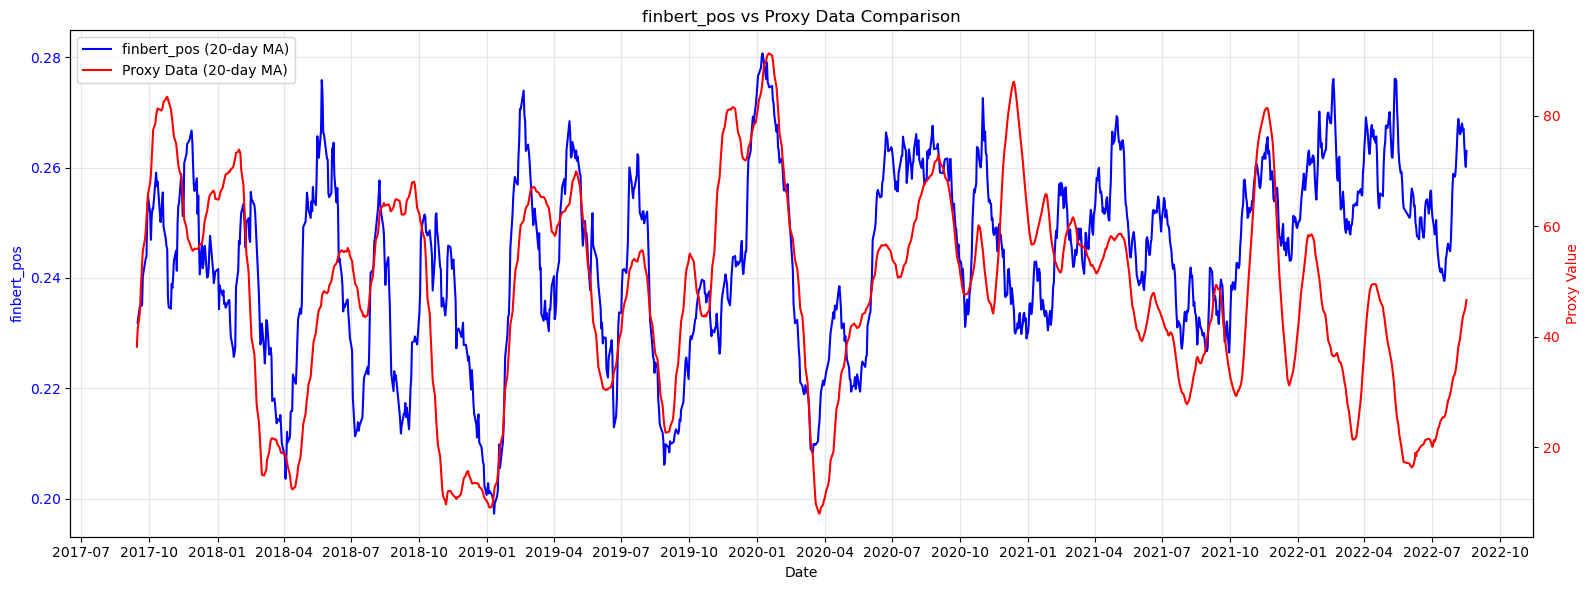

In [7]:
# finbert analysis
sentiment_contrast(finert_famc_w, sentiment_proxy, 'finbert_pos')

In [18]:
corr_test(finert_famc_w, finert_famc_s, btc_d, 'finbert', 10, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.050369,0.004300,-0.087552,0.027175,-0.024492,-0.009256,-0.008415,-0.007828,-0.003178,-0.077733,-0.014712,-0.022482
finbert_neg,0.018434,-0.003403,-0.074233,-0.070667,-0.059822,-0.050880,-0.028420,-0.041788,-0.003571,-0.079223,-0.132761,-0.051589
pos_r,-0.047010,-0.044452,-0.125401,0.018793,-0.033466,-0.025290,0.026957,-0.061967,0.012045,-0.186351,-0.136825,-0.004059
pos_n,-0.035504,0.030565,-0.209836,-0.061780,-0.049821,-0.081328,0.051263,-0.109886,-0.042749,-0.123637,-0.174639,-0.067022


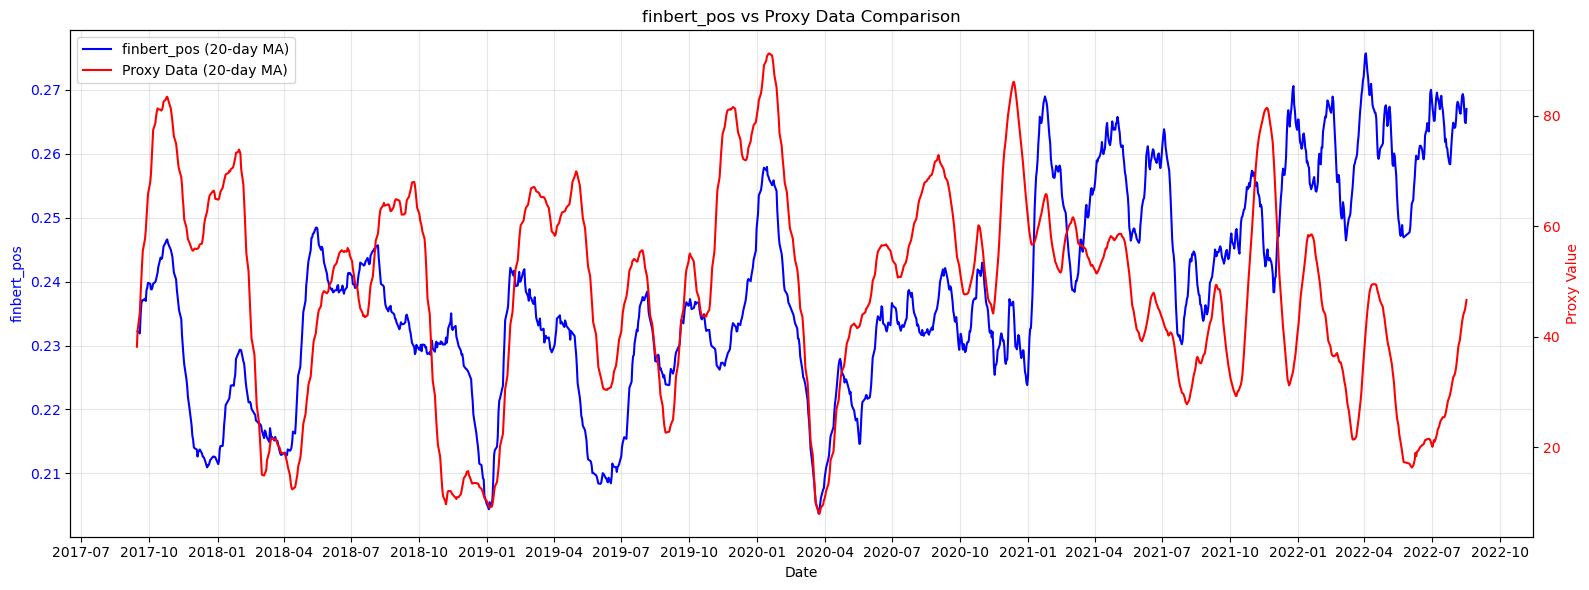

In [10]:
sentiment_contrast(finert_logfamc_w, sentiment_proxy, 'finbert_pos')

In [14]:
sentiment_proxy['20_mean_p'] = sentiment_proxy['close_value'].rolling(20).mean()
finert_logfamc_w_ = finert_logfamc_w.copy()
finert_logfamc_w_['20_mean'] = finert_logfamc_w_['finbert_pos'].rolling(20).mean()
sentiment_proxy['dt'] = sentiment_proxy['dt'].astype(str)

In [15]:
market_test(finert_logfamc_w_.dropna(), sentiment_proxy.dropna(), '20_mean', '20_mean_p')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.5051 , p=0.0000  , df_denom=1430, df_num=1
ssr based chi2 test:   chi2=17.5418 , p=0.0000  , df=1
likelihood ratio test: chi2=17.4353 , p=0.0000  , df=1
parameter F test:         F=17.5051 , p=0.0000  , df_denom=1430, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4723  , p=0.0006  , df_denom=1427, df_num=2
ssr based chi2 test:   chi2=14.9970 , p=0.0006  , df=2
likelihood ratio test: chi2=14.9190 , p=0.0006  , df=2
parameter F test:         F=7.4723  , p=0.0006  , df_denom=1427, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7673  , p=0.0026  , df_denom=1424, df_num=3
ssr based chi2 test:   chi2=14.3721 , p=0.0024  , df=3
likelihood ratio test: chi2=14.3004 , p=0.0025  , df=3
parameter F test:         F=4.7673  , p=0.0026  , df_denom=1424, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1075  , p=0.

({1: ({'ssr_ftest': (17.50510254620049, 3.0398329649257994e-05, 1430.0, 1),
    'ssr_chi2test': (17.54182653755615, 2.8105632404765087e-05, 1),
    'lrtest': (17.435327138558932, 2.9724985142451744e-05, 1),
    'params_ftest': (17.50510254646397, 3.0398329645098073e-05, 1430.0, 1.0)},
    array([[0., 1., 0.]])]),
  2: ({'ssr_ftest': (7.472310685943986, 0.000591142234091748, 1427.0, 2),
    'ssr_chi2test': (14.996985146842029, 0.0005539187329401446, 2),
    'lrtest': (14.918999283327139, 0.0005759442779238155, 2),
    'params_ftest': (7.472310685861842, 0.0005911422341397822, 1427.0, 2.0)},
    array([[0., 0., 1., 0., 0.],
           [0., 0., 0., 1., 0.]])]),
  3: ({'ssr_ftest': (4.767258423896706, 0.0026015990871994838, 1424.0, 3),
    'ssr_chi2test': (14.372078942267247, 0.002440047616934838, 3),
    'lrtest': (14.300386430189974, 0.002523520979009636, 3),
    'params_ftest': (4.767258423903816, 0.0026015990871738025, 1424.0, 3.0)},
    array([[0., 0., 0., 1., 0., 0., 0.],
           

In [21]:
corr_test(finert_logfamc_w, finert_logfamc_s, btc_d, 'finbert', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.166241,-0.110185,-0.153999,-0.120449,-0.059934,-0.097444,-0.158528,-0.101244,-0.067186,-0.127039,-0.141771,-0.163726
finbert_neg,0.028619,-0.078755,-0.129115,-0.032550,-0.077717,-0.107867,-0.030537,-0.129239,-0.023844,-0.161615,-0.092878,-0.094059
pos_r,-0.151726,-0.097358,-0.188036,-0.126318,-0.094673,-0.096530,-0.174583,-0.123198,-0.071958,-0.227490,-0.200492,-0.161488
pos_n,0.056700,-0.116416,-0.218043,-0.047159,-0.129830,-0.170128,-0.080633,-0.220110,-0.021464,-0.228379,-0.108641,-0.130555


In [7]:
crypto_test(finert_logfamc_w, finert_logfamc_s, btc_d, 'finbert')

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     7.339
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           7.32e-06
Time:                        21:22:34   Log-Likelihood:                 1784.7
No. Observations:                1844   AIC:                            -3559.
Df Residuals:                    1839   BIC:                            -3532.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1029      0.025     44.446 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565,0.019565
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.086069,-0.085999,-0.061245,-0.057645,-0.019070,-0.053243,-0.073901,-0.033536,-0.014251,-0.040013,-0.053473,-0.074905
finbert_neg,0.008229,-0.034404,-0.075176,-0.011120,-0.049645,-0.052179,-0.019803,-0.043093,-0.002048,-0.079225,-0.082159,-0.047837
pos_r,-0.124483,-0.088280,-0.135402,-0.102026,-0.067568,-0.086409,-0.112248,-0.112328,-0.067434,-0.132428,-0.136140,-0.124051
pos_n,0.030863,-0.052622,-0.089409,-0.016281,-0.075575,-0.078641,-0.011634,-0.095854,-0.024288,-0.131226,-0.049165,-0.054058


In [20]:
corr_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index < '2020-04-01'], 'finbert', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.034207,-0.018668,-0.072679,-0.097947,0.013315,-0.094883,-0.114487,-0.066607,-0.040328,-0.025018,-0.050753,-0.103533
finbert_neg,-0.024463,-0.041098,-0.094064,-0.013999,-0.028356,-0.014818,0.046073,-0.089266,0.032561,-0.048681,-0.066555,-0.031914
pos_r,0.058375,0.108337,-0.015425,-0.086232,0.091606,-0.076437,-0.075629,-0.009293,-0.082706,-0.035133,-0.026294,-0.038108
pos_n,0.040464,-0.052402,-0.148873,0.058356,0.038969,0.002412,0.063781,-0.139177,0.158286,-0.002537,-0.027966,0.003244


In [23]:
crypto_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index < '2020-04-01'], 'finbert')

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.941
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.102
Time:                        21:36:43   Log-Likelihood:                 828.01
No. Observations:                 949   AIC:                            -1646.
Df Residuals:                     944   BIC:                            -1622.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0816      0.056     19.426 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184,0.019184
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,0.015932,-0.061029,-0.034937,-0.070906,0.008772,-0.059671,-0.094608,-0.030757,0.014778,0.026259,0.003956,-0.060723
finbert_neg,-0.047393,-0.016466,-0.071456,-0.012261,-0.049173,-0.015314,-0.007737,-0.021495,-0.013334,-0.043644,-0.092249,-0.040223
pos_r,-0.048983,-0.015777,-0.075038,-0.090740,0.015726,-0.091179,-0.086242,-0.083444,-0.072608,-0.065322,-0.064904,-0.088576
pos_n,0.006312,-0.023076,-0.051087,0.016469,-0.022611,-0.001113,0.052644,-0.062565,0.038437,-0.022104,-0.017486,-0.000165


In [24]:
corr_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index >= '2020-04-01'], 'finbert', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.324507,-0.237971,-0.256128,-0.162834,-0.166301,-0.086952,-0.231995,-0.147686,-0.100624,-0.239113,-0.251494,-0.258850
finbert_neg,0.050619,-0.161520,-0.214083,-0.114976,-0.167632,-0.240318,-0.142298,-0.208888,-0.125723,-0.324978,-0.180875,-0.213356
pos_r,-0.347572,-0.361201,-0.393568,-0.252432,-0.335608,-0.096725,-0.322566,-0.309803,-0.066021,-0.417026,-0.404075,-0.353656
pos_n,0.021598,-0.242341,-0.356986,-0.206239,-0.334600,-0.361629,-0.247142,-0.345751,-0.309508,-0.489835,-0.265211,-0.316126


In [25]:
crypto_test(finert_logfamc_w, finert_logfamc_s, btc_d[btc_d.index >= '2020-04-01'], 'finbert')

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     17.40
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           9.38e-14
Time:                        21:37:46   Log-Likelihood:                 990.87
No. Observations:                 887   AIC:                            -1972.
Df Residuals:                     882   BIC:                            -1948.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2647      0.040     31.651 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486,0.021486
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.204787,-0.137039,-0.101429,-0.059347,-0.063496,-0.045610,-0.074235,-0.043441,-0.054933,-0.110443,-0.124957,-0.113002
finbert_neg,0.068815,-0.071616,-0.090456,-0.027173,-0.056368,-0.098910,-0.045334,-0.076007,0.015447,-0.131772,-0.089725,-0.070013
pos_r,-0.238087,-0.222069,-0.240321,-0.190952,-0.210347,-0.073138,-0.183302,-0.192776,-0.089349,-0.220463,-0.239240,-0.224273
pos_n,0.041103,-0.114468,-0.157915,-0.079231,-0.151045,-0.163935,-0.090182,-0.148566,-0.127403,-0.270534,-0.117277,-0.132791


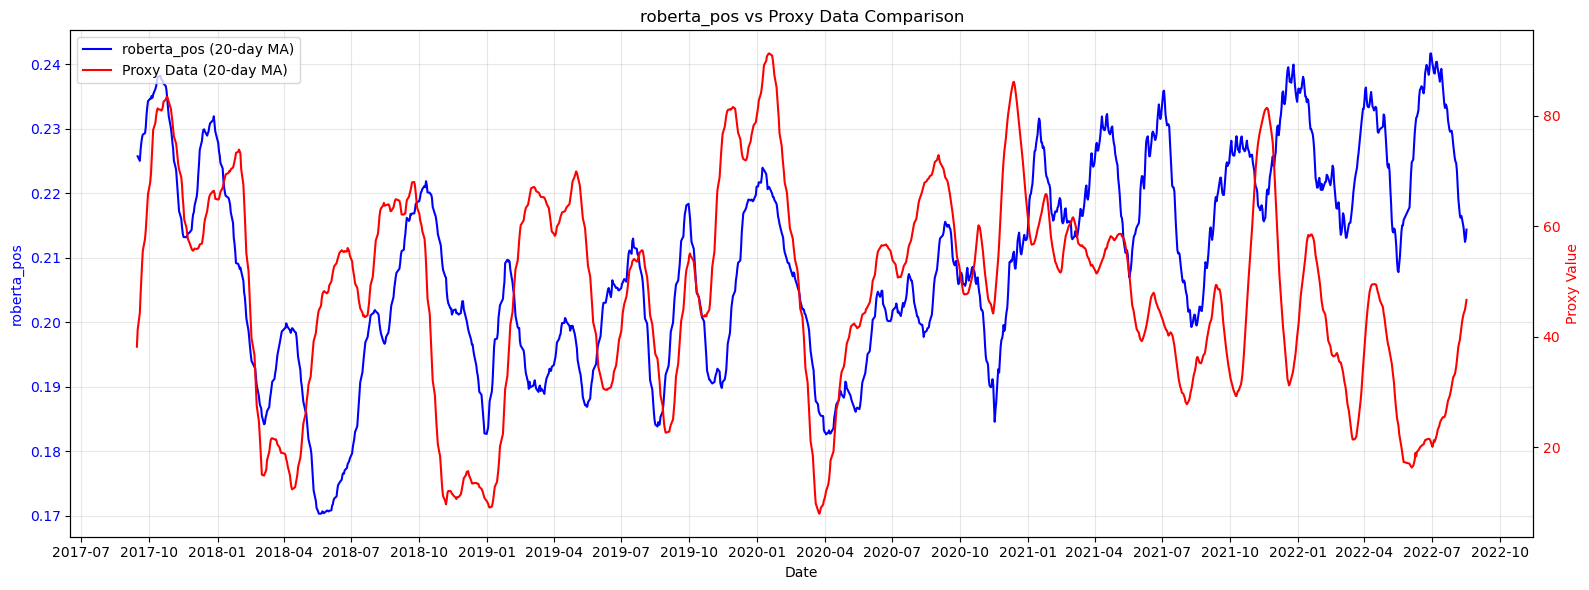

In [16]:
# roberta analysis
sentiment_contrast(roberta_logfamc_w, sentiment_proxy, 'roberta_pos')

In [24]:
corr_test(roberta_logfamc_w, roberta_logfamc_s, btc_d, 'roberta', 2, 10)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
roberta_pos,-0.027193,-0.027276,0.008535,-0.010082,-0.006147,0.026033,-0.024298,0.014478,0.007723,0.022118,0.017743,-0.000605
roberta_neg,0.012006,-0.013452,-0.027729,0.001956,-0.021864,-0.006577,-0.007583,0.004451,0.058625,-0.055100,-0.040285,-0.003413
pos_r,-0.031274,-0.012173,0.012144,0.001533,0.017623,0.023371,-0.005329,0.036259,0.015283,0.015295,0.002674,0.009257
pos_n,0.042601,-0.038975,-0.019314,0.019957,0.005527,0.022017,0.026330,0.010314,0.042120,-0.038848,-0.023303,0.014386


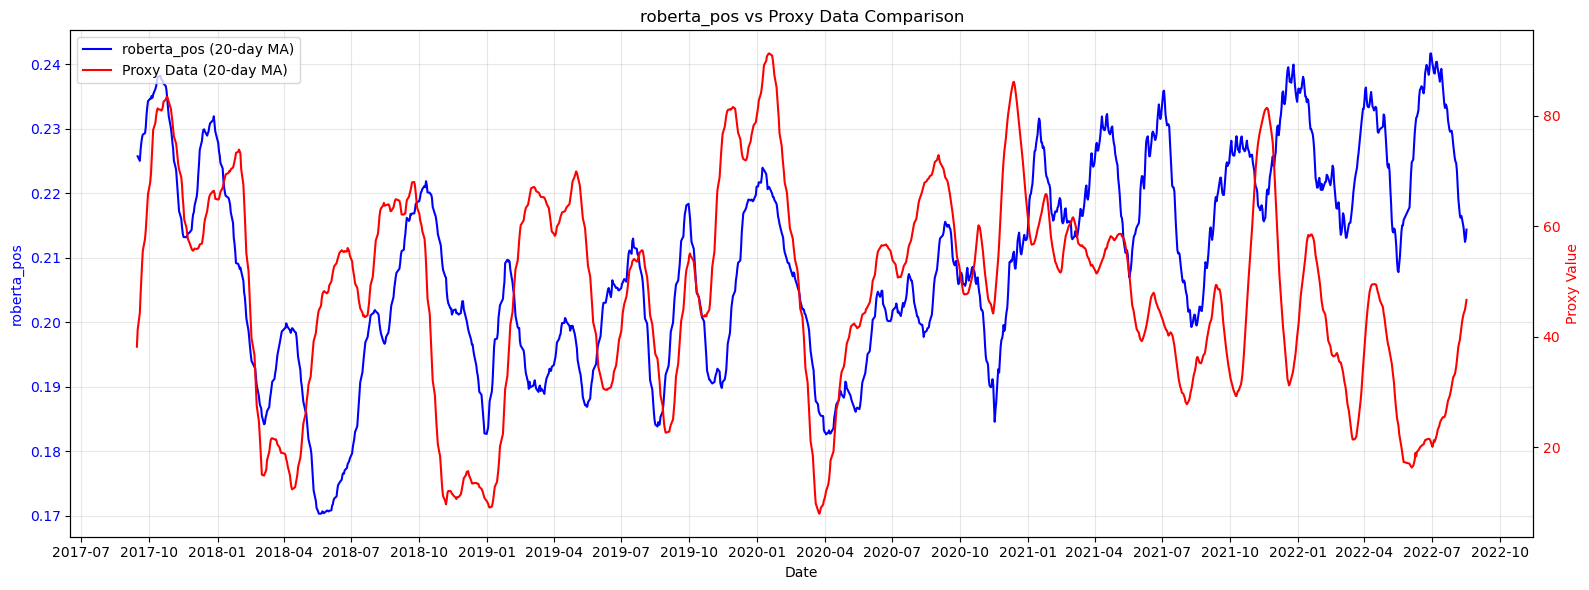

In [18]:
sentiment_contrast(roberta_logfamc_w, sentiment_proxy, 'roberta_pos')

In [27]:
corr_test(roberta_logfamc_w, roberta_logfamc_s, btc_d, 'roberta', 3, 5)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
roberta_pos,-0.034397,-0.027522,0.013256,-0.004300,-0.000904,0.040243,-0.018513,0.021581,0.021068,0.018407,0.020266,0.005609
roberta_neg,0.035161,-0.018913,-0.036348,0.010146,-0.009029,-0.000373,0.000244,0.017454,0.056761,-0.054633,-0.041632,0.004470
pos_r,-0.039986,-0.035559,0.008991,0.004372,0.029044,0.039016,-0.013442,0.041407,0.031206,0.019613,0.005851,0.010390
pos_n,0.047697,-0.035913,-0.033776,0.031606,0.020614,0.040641,0.027631,0.007619,0.054653,-0.049059,-0.036755,0.020443


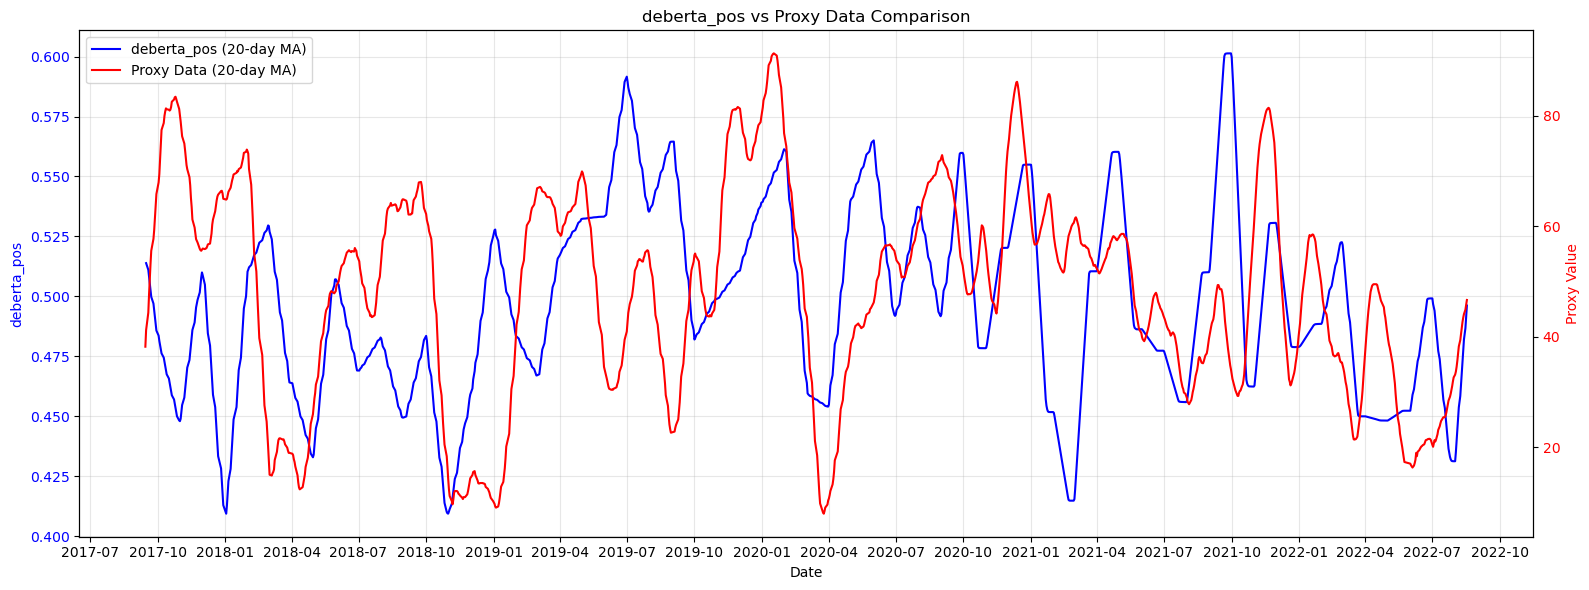

In [20]:
# deberta analysis
sentiment_contrast(deberta_logfamc_w, sentiment_proxy, 'deberta_pos')

In [28]:
corr_test(deberta_logfamc_w, deberta_logfamc_s, btc_d, 'deberta', 10, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
deberta_pos,0.100662,0.100749,0.100667,0.097630,0.097485,0.101301,0.100293,0.098658,0.097533,0.100540,0.100167,0.100223
deberta_neg,-0.100662,-0.100749,-0.100667,-0.097630,-0.097485,-0.101301,-0.100293,-0.098658,-0.097533,-0.100540,-0.100167,-0.100223
pos_r,0.138246,0.137764,0.137772,0.138292,0.138125,0.137075,0.137808,0.138042,0.137732,0.138507,0.136820,0.137957
pos_n,-0.138246,-0.137764,-0.137772,-0.138292,-0.138125,-0.137075,-0.137808,-0.138042,-0.137732,-0.138507,-0.136820,-0.137957


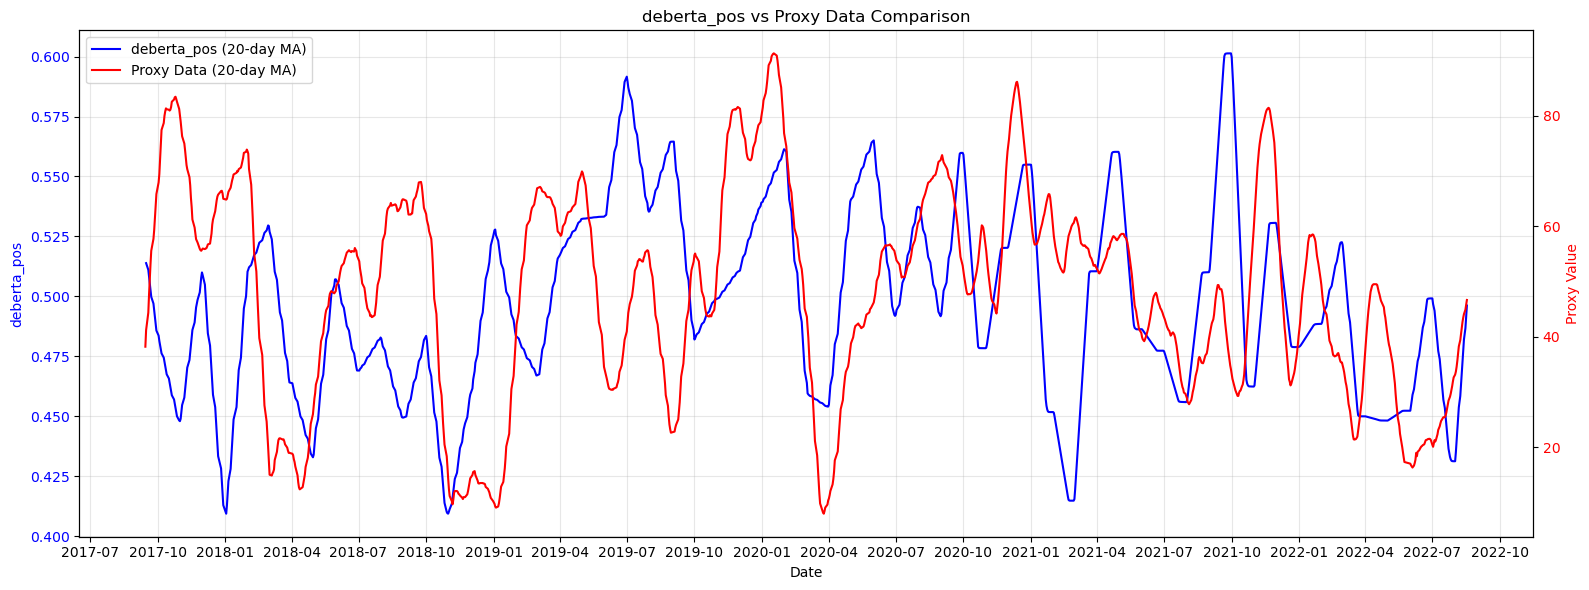

In [30]:
sentiment_contrast(deberta_logfamc_w, sentiment_proxy, 'deberta_pos')

In [38]:
corr_test(deberta_logfamc_w, deberta_logfamc_s, btc_d, 'deberta', 20, 20)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
deberta_pos,0.164168,0.163981,0.163911,0.162852,0.162568,0.163739,0.163872,0.163178,0.162674,0.164200,0.162882,0.163914
deberta_neg,-0.164168,-0.163981,-0.163911,-0.162852,-0.162568,-0.163739,-0.163872,-0.163178,-0.162674,-0.164200,-0.162882,-0.163914
pos_r,0.171295,0.170475,0.170982,0.171818,0.171469,0.170075,0.170717,0.171266,0.171002,0.172404,0.169842,0.171124
pos_n,-0.171295,-0.170475,-0.170983,-0.171818,-0.171469,-0.170075,-0.170717,-0.171266,-0.171002,-0.172404,-0.169842,-0.171124


In [10]:
factor_test = finert_logfamc_s[20]['finbert_pos'].rolling(20).mean() + finert_logfamc_s[60]['finbert_pos'].rolling(20).mean() + finert_logfamc_s[55]['finbert_pos'].rolling(20).mean()

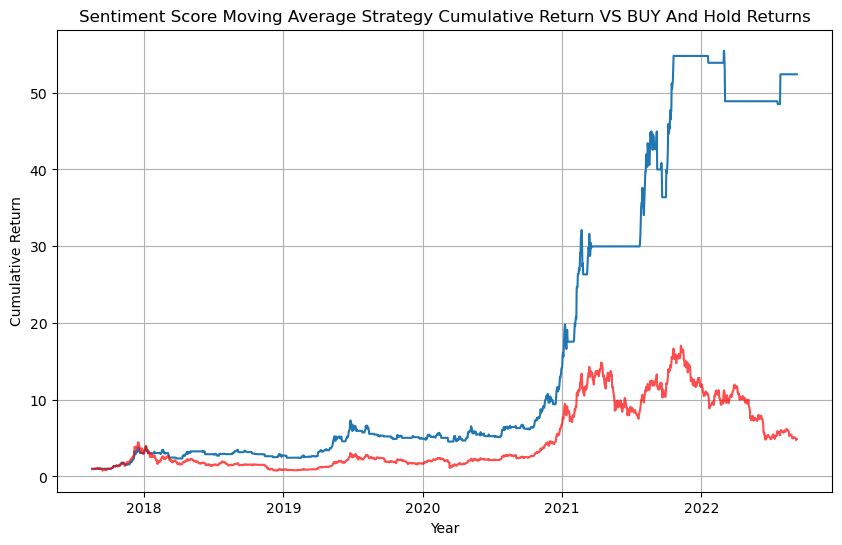

52.394538582653354

In [11]:
sentiment_strategy(factor_test, btc_d, 0.75)

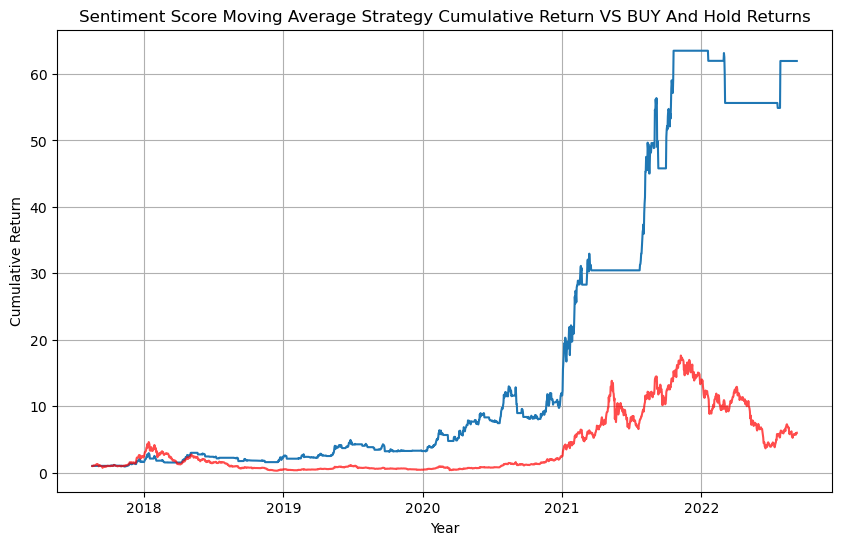

61.96405963990824

In [120]:
sentiment_strategy(factor_test, eth_d, 0.75)

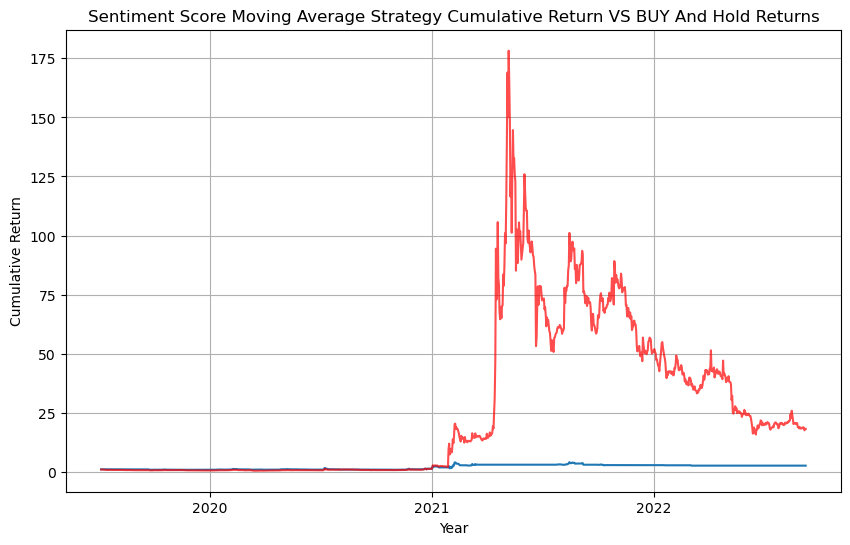

2.5607259131001796

In [119]:
sentiment_strategy(factor_test, doge_d, 0.75)

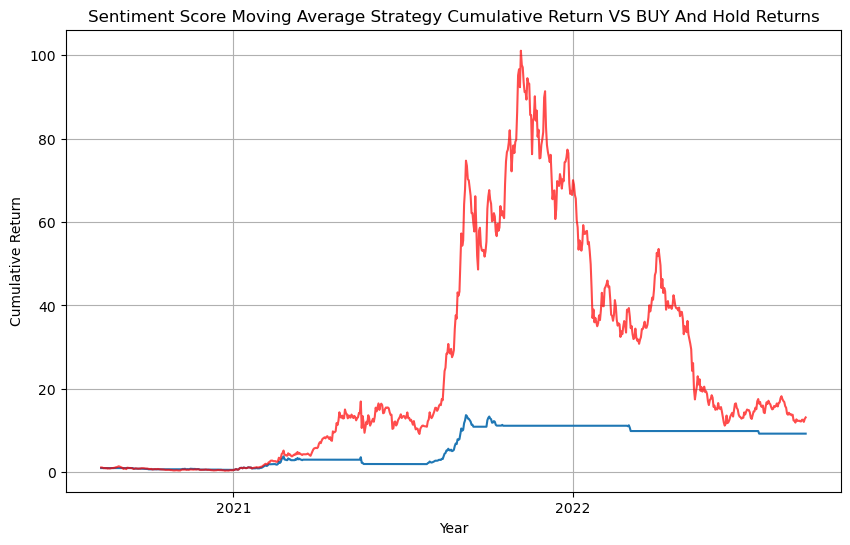

9.256454147951594

In [118]:
sentiment_strategy(factor_test, sol_d, 0.75)